----
# QDA classification using sklearn

----

In [567]:
%load_ext autoreload
%autoreload 2

from sklearn.metrics import confusion_matrix as skconfmatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Set correct working directory
if os.getcwd() != os.path.abspath("../Python"):
    os.chdir("../../Python")

# Import files from /Python directory
from confusion_matrix import confusion_matrix
"""
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmr"
})
"""

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\nplt.rcParams.update({\n    "text.usetex": True,\n    "font.family": "cmr"\n})\n'

In [657]:
config = {
    "standardize" : True,
    "lda-reduce" : 4,
    "classifier" : "qda",
    "keep_features" : 12,
}

In [658]:
# Load data sets
trn_data = pd.read_csv(f"../TrainingData/neodata/soltani_14d_nonoise_1200.csv")
vld_data = pd.read_csv(f"../ValidationData/neodata/soltani_14d_nonoise_1200.csv")
tst_data = pd.read_csv(f"../TestData/neodata/soltani_14d_nonoise_100.csv")

# Separate into data and targets
y_trn = trn_data.pop('target')
X_trn = trn_data#.assign(single=np.ones((len(y_trn),)))

y_vld = vld_data.pop('target')
X_vld = vld_data#.assign(single=np.ones((len(y_vld),)))

y_tst = tst_data.pop('target')
X_tst = tst_data#.assign(single=np.ones((len(y_tst),)))

## Standardize data (z-norm)

In [659]:

if config["standardize"]:
    from sklearn.preprocessing import StandardScaler
    standardizer = StandardScaler()
    
    cols = X_trn.columns

    X_trn_std = standardizer.fit_transform(X_trn)
    X_vld_std = standardizer.transform(X_vld)
    X_tst_std = standardizer.transform(X_tst)

    X_trn_std = pd.DataFrame(X_trn_std,columns = cols)
    X_vld_std = pd.DataFrame(X_vld_std,columns = cols)
    X_tst_std = pd.DataFrame(X_tst_std,columns = cols)
else:
    X_trn_std = X_trn
    X_vld_std = X_vld
    X_tst_std = X_tst

----
## Feature selection

In [660]:
def feature_conditioner_1(X):
    
    all_features = list(X.columns)
    removal = []
    conditioning = [np.linalg.cond(X)]
    for _ in range(len(X.columns)-1):
        conds = {}
        for feature in all_features:
            if feature not in removal:
                temp = removal.copy()
                temp.append(feature)
                conds[feature] = np.linalg.cond(X.drop(columns=temp))
        # print(f"{min(conds,key=conds.get)} : {conds}")
        all_features.remove(min(conds,key=conds.get))
        removal.append(min(conds,key=conds.get))
        conditioning.append(np.linalg.cond(X.drop(columns=removal)))
    return removal,conditioning

def feature_conditioner_2(X,y):
    
    all_features = list(X.columns)
    
    removal = []
    conditioning = [np.linalg.norm( [np.linalg.cond(X[y == c].cov()) for c in y.unique()])]
    for _ in range(len(X.columns)-1):
        conds = {}
        for feature in all_features:
            if feature not in removal:
                temp = removal.copy()
                temp.append(feature)
                conds[feature] = np.linalg.norm( [np.linalg.cond(X[y == c].cov().drop(columns=temp)) for c in y.unique()])
        # print(f"{min(conds,key=conds.get)} : {conds}")
        all_features.remove(min(conds,key=conds.get))
        removal.append(min(conds,key=conds.get))
        conditioning.append(np.linalg.norm( [np.linalg.cond(X[y == c].cov().drop(columns=removal)) for c in y.unique()]))
    removal.append(all_features[0])
    return removal,conditioning


removal,conditioning = feature_conditioner_1(X_trn_std)
# removal,conditioning = feature_conditioner_2(X_trn_std,y_trn)

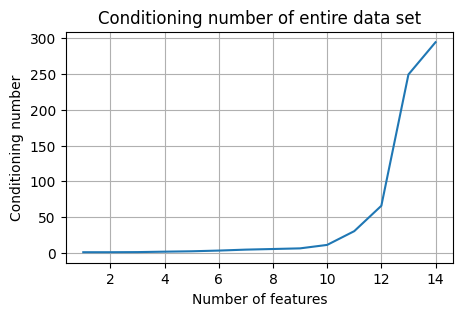

In [675]:
fig,(axs1) = plt.subplots(1,1,figsize = (5,3))
axs1.plot( np.flip([x for x in range(1,(len(conditioning)+1))]), conditioning )
axs1.set_xlabel("Number of features")
axs1.set_ylabel("Conditioning number")
axs1.set_title("Conditioning number of entire data set")
axs1.grid()

In [677]:
if config["keep_features"] != False:
    print(f"Dropping : { removal[0:15-config['keep_features']] }")
    X_trn_drop = X_trn_std.drop(columns = removal[0:15-config["keep_features"]])
    X_vld_drop = X_vld_std.drop(columns = removal[0:15-config["keep_features"]])
    X_tst_drop = X_tst_std.drop(columns = removal[0:15-config["keep_features"]])
    X_trn_drop.head()
else:
    X_trn_drop = X_trn_std
    X_vld_drop = X_vld_std
    X_tst_drop = X_tst_std
X_trn_drop.columns

Dropping : ['T0', 'Density', 'Pdis']


Index(['Psuc', 'Tc', 'Tdis', 'Tret', 'Tsuc', 'Tsh', 'Tsup', 'CondFan',
       'CprPower', 'Tamb', 'Tset'],
      dtype='object')

In [663]:
# # Remove two additional features
# X_trn_drop = X_trn_drop.drop(columns = ['CondFan','CprPower'])
# X_vld_drop = X_vld_drop.drop(columns = ['CondFan','CprPower'])
# X_tst_drop = X_tst_drop.drop(columns = ['CondFan','CprPower'])
# X_trn_drop.columns

In [664]:
# All temperatures except T0
X_trn_drop = X_trn_std.drop(columns = ['T0', 'Density', 'Pdis', 'Psuc','CondFan','CprPower'])
X_vld_drop = X_vld_std.drop(columns = ['T0', 'Density', 'Pdis', 'Psuc','CondFan','CprPower'])
X_tst_drop = X_tst_std.drop(columns = ['T0', 'Density', 'Pdis', 'Psuc','CondFan','CprPower'])
X_trn_drop.columns

Index(['Tc', 'Tdis', 'Tret', 'Tsuc', 'Tsh', 'Tsup', 'Tamb', 'Tset'], dtype='object')

In [665]:
# X_trn_drop = X_trn_std.drop(columns = ['Density', 'Psuc', 'Psuc','CondFan','CprPower','Tc','Tamb','Tsup','Tsuc'])
# X_vld_drop = X_vld_std.drop(columns = ['Density', 'Psuc', 'Psuc','CondFan','CprPower','Tc','Tamb','Tsup','Tsuc'])
# X_tst_drop = X_tst_std.drop(columns = ['Density', 'Psuc', 'Psuc','CondFan','CprPower','Tc','Tamb','Tsup','Tsuc'])
# X_trn_drop.columns

Conditioning of Sw : 60654.49
Preserving 94.13% of variance
Conditioning of Sw : 172.09
Preserving 99.7% of variance


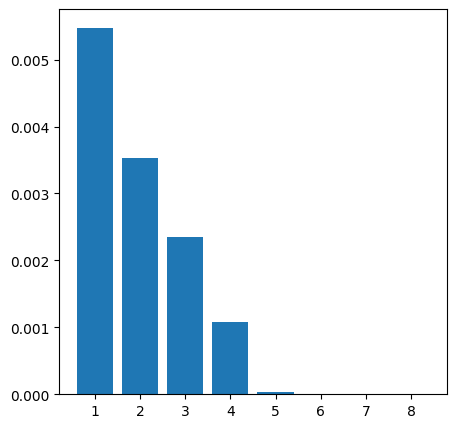

In [666]:

if config["lda-reduce"] != False:
    import lda
    # reducer = lda.reducer(X_trn_std,y_trn,config["lda-reduce"])
    reducer = lda.reducer(X_trn_drop,y_trn,config["lda-reduce"])

    X_trn_red = reducer.transform(X_trn_drop)
    X_tst_red = reducer.transform(X_tst_drop)
    X_vld_red = reducer.transform(X_vld_drop)
else:
    X_trn_red = X_trn_drop
    X_tst_red = X_tst_drop
    X_vld_red = X_vld_drop

---

# Train classifiers

In [667]:
if config["classifier"] == "qda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
    clf = qda.fit(X_trn_red,y_trn)
    
elif config["classifier"] == "lda":
    from sklearn import discriminant_analysis
    qda = discriminant_analysis.LinearDiscriminantAnalysis()
    clf = qda.fit(X_trn_std,y_trn)
    
elif config["classifier"] == "lda_self":
    import lda
    clf = lda.classifier(X_trn_red,y_trn)

elif config["classifier"] == "svm":
    from sklearn import svm
    clf = svm.SVC( C=1000, decision_function_shape="ovo", gamma=.01 )
    clf.fit(X_trn_red,y_trn)

In [668]:
# import qda
# vld_acc = []
# tst_acc = []
# vld_cond = []
# for i in range(13):
    
#     features = removal[i:15]

#     X_trn_drop = X_trn_std[features]
#     X_vld_drop = X_vld_std[features]
#     X_tst_drop = X_tst_std[features]
    
#     vld_cond.append( np.linalg.cond(X_trn_drop) )

#     clf = qda.classifier(X_trn_drop,y_trn)

#     y_hat_vld = clf.predict(X_vld_drop)
#     y_hat_tst = clf.predict(X_tst_drop)

#     vld_acc.append(sum(y_hat_vld == y_vld)/len(y_vld))
#     tst_acc.append(sum(y_hat_tst == y_tst)/len(y_tst))

# Classifying training data

In [669]:
# Define naming strings
str_feature = f"F{x}-" if (x:=config["keep_features"]) else ""
str_lda = f"LDA{x}-" if (x:=config["lda-reduce"]) else ""
str_classifier = str(config["classifier"]).upper()

In [671]:
# # Make predictions for the training set
# y_hat_trn = clf.predict(X_trn_red)

# #plot the confusion matrix
# conf_matrix_trn = skconfmatrix(y_trn,y_hat_trn)
# confusion_matrix(
#     conf_matrix_trn,
#     title = f'{str_feature}{str_lda}{str_classifier} of training set',
#     save_fig_name = f'{str_feature}{str_lda}{str_classifier}-training.pdf')

# Classifying validation data

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'F12-LDA4-QDA of validation set : Accuracy 87.667%'}, xlabel='Predicted class', ylabel='True class'>)

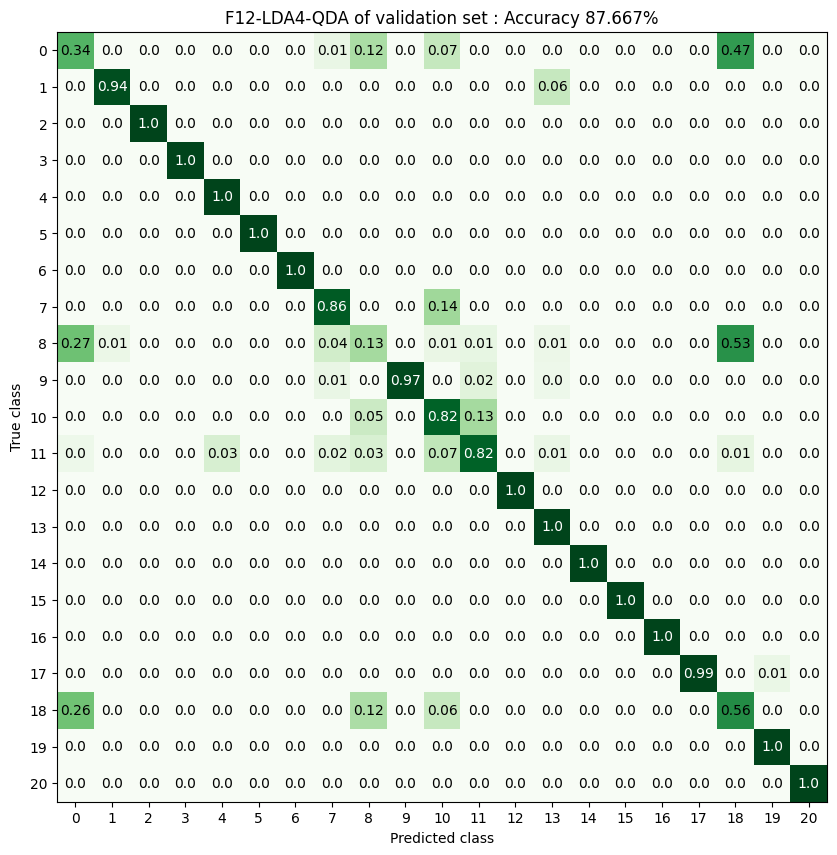

In [672]:
# Make predictions for the training set
y_hat_vld = clf.predict(X_vld_red)

#plot the confusion matrix
conf_matrix_vld = skconfmatrix(y_vld,y_hat_vld)
confusion_matrix(
    conf_matrix_vld,
    title = f'{str_feature}{str_lda}{str_classifier} of validation set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-validation.pdf')

# Classifying test data

(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'F12-LDA4-QDA of test set : Accuracy 90.476%'}, xlabel='Predicted class', ylabel='True class'>)

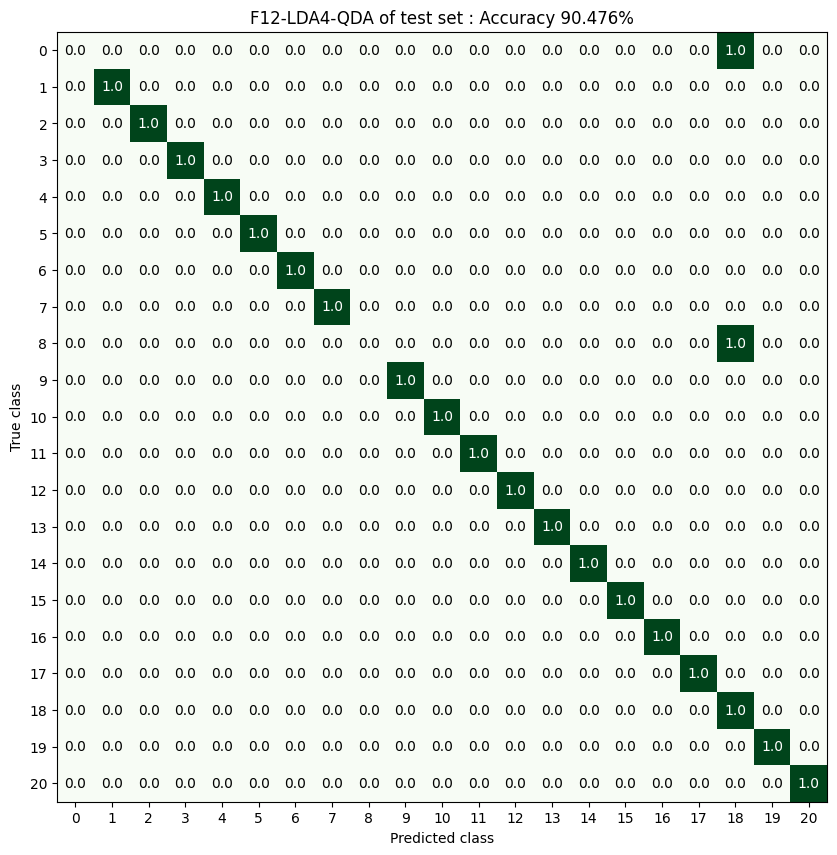

In [673]:
# Make predictions for the training set
y_hat_tst = clf.predict(X_tst_red)

#plot the confusion matrix
conf_matrix_tst = skconfmatrix(y_tst,y_hat_tst)
confusion_matrix(
    conf_matrix_tst,
    title = f'{str_feature}{str_lda}{str_classifier} of test set',
    save_fig_name = f'{str_feature}{str_lda}{str_classifier}-test.pdf')